

This is my version of classification for finding out what was the survival chance of someone on the board of the Titanic give the demographic info about him/her. 

**Outlines:**
* Analysing the data and finding the associations between them.
* Filling the missing data according to the found correlations.
* Conducting a Chi_squared analysis to quantify the associations. 
* Training a logistic classifier.
* Training and optimizing the hyperparameters of a Random Forest Classifier.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import os
#print(os.listdir(r"/input"))

# Any results you write to the current directory are saved as output.
train_data = pd.read_csv('train.csv')
print(train_data.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Now, I need to know what is missing. The following gives me stats of NAN data in my dataframe. Fortunately, all missing cells are empty and I don't have to deal with replacing strange characters!

In [9]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Let's leave the missing ones for a while and come back to them after a brief look at the data. Here, I plot the overall survival rate, gender, class, and age group. My guess is that the last three ones have the highest impact on the survival rate.

Text(0.5, 1, 'Number of Parents/Children Aboard')

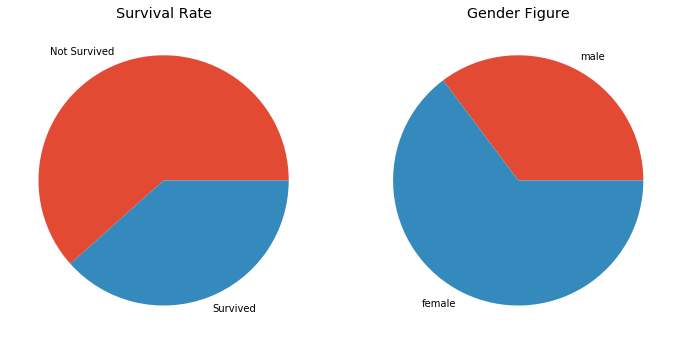

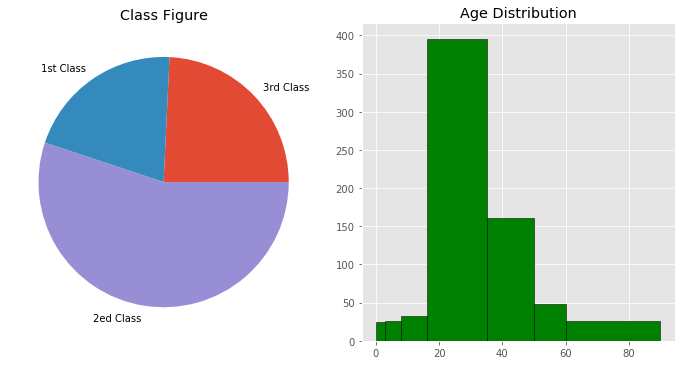

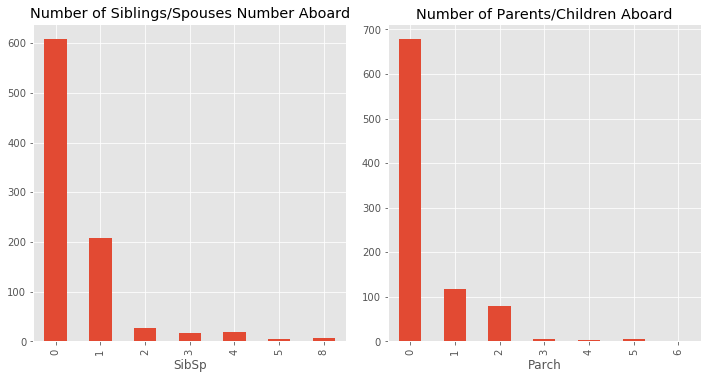

In [10]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
axes[0].pie(train_data.groupby(['Survived'])['PassengerId'].count(),labels = ['Not Survived','Survived'])
axes[0].set_title("Survival Rate")        
axes[1].pie(train_data.groupby(['Sex'])['PassengerId'].count(),labels = train_data['Sex'].unique())
axes[1].set_title("Gender Figure")

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
axes[0].pie(train_data.groupby(['Pclass'])['PassengerId'].count(),labels = ['3rd Class','1st Class','2ed Class'])
axes[0].set_title("Class Figure")
age_bins = [0,3,8,16,35,50,60,90]
train_data['AgeGroup'] = pd.cut(train_data['Age'].dropna(),[0,3,8,16,35,50,60,90],labels = ['0-3','4-8','9-16','17-35','36-50','51-60','61- '])
axes[1].set_title("Age Distribution")
axes[1].hist(train_data['Age'].dropna(),age_bins,facecolor='green',edgecolor='black')
axes[1].grid(True)

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
train_data.groupby(['SibSp'])['Survived'].count().plot.bar(stacked = True, ax = axes[0])
axes[0].set_title("Number of Siblings/Spouses Number Aboard") 
train_data.groupby(['Parch'])['Survived'].count().plot.bar(stacked = True, ax = axes[1])
axes[1].set_title("Number of Parents/Children Aboard") 


The survival rate, according to the variables, is plotted in the next set of figures. It is clear that there is a strong association between these variables and survival rate, however, due to the difference in numbers, they don't have equal significance. The plots imply that the survival chance is correlated to the Class, Gender, Age Group, number of siblings, spouses, children and parents aboard.

Text(0.5, 1, 'Survival Rate Based \n Age Group')

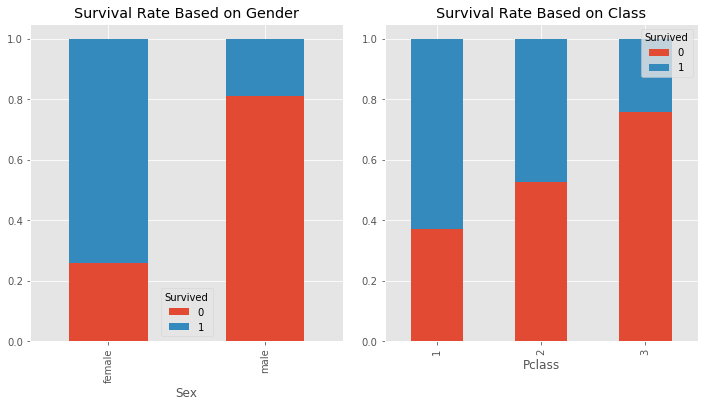

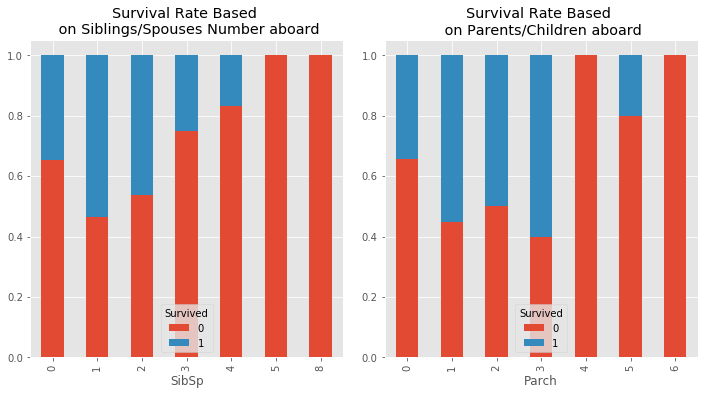

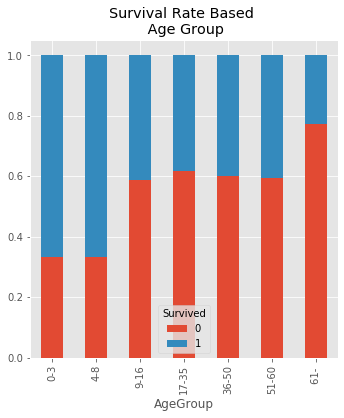

In [11]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
train_data.groupby(['Sex'])['Survived'].value_counts().div(train_data.groupby(['Sex'])['Survived'].count()).unstack().plot.bar(stacked = True, ax=axes[0])
axes[0].set_title("Survival Rate Based on Gender")  
train_data.groupby(['Pclass'])['Survived'].value_counts().div(train_data.groupby(['Pclass'])['Survived'].count()).unstack().plot.bar(stacked = True, ax = axes[1])
axes[1].set_title("Survival Rate Based on Class")

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
train_data.groupby(['SibSp'])['Survived'].value_counts().div(train_data.groupby(['SibSp'])['Survived'].count()).unstack().plot.bar(stacked = True, ax = axes[0])
axes[0].set_title("Survival Rate Based \n on Siblings/Spouses Number aboard") 
train_data.groupby(['Parch'])['Survived'].value_counts().div(train_data.groupby(['Parch'])['Survived'].count()).unstack().plot.bar(stacked = True, ax = axes[1])
axes[1].set_title("Survival Rate Based \n on Parents/Children aboard") 
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.tight_layout()
train_data.groupby(['AgeGroup'])['Survived'].value_counts().div(train_data.groupby(['AgeGroup'])['Survived'].count()).unstack().plot.bar(stacked = True, ax=ax)
ax.set_title("Survival Rate Based \n Age Group") 

The relationship between the fare price and class as well as survival is depicted here. It shows a correlation in between the class and fair price, as it is expected, and also the survival chance and the fare, with a considerable number of outliers. It seems that this variable does not offer additional information than the Class data does.

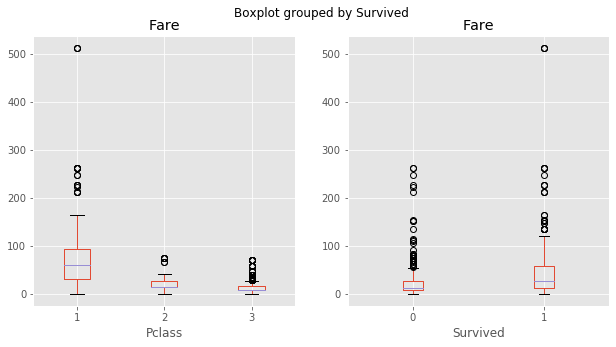

In [12]:
fig, axes = plt.subplots(1,2,figsize = (10,5))
train_data.boxplot(column = 'Fare',by = 'Pclass',ax = axes[0])
train_data.boxplot(column = 'Fare',by = 'Survived',ax = axes[1])

There are NANs in three columns corresponding to age, embarking location, and cabin with 177, 2, and 687 NAN numbers, respectively. The embarking location only has 2 NANs, so I disregard them and just remove the rows. For Age missing values, there are two options. The first one, which is the easier, is to replace all missing values with the age median of the whole population. The second method is to fill them with respect to the other non-missing properties of the population. Let's take a look to see if there is a relation between the age and the class of the non-missing data.

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64
Sex
female    27.0
male      29.0
Name: Age, dtype: float64
Embarked
C    29.0
Q    27.0
S    28.0
Name: Age, dtype: float64
Survived
0    28.0
1    28.0
Name: Age, dtype: float64


<Figure size 720x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

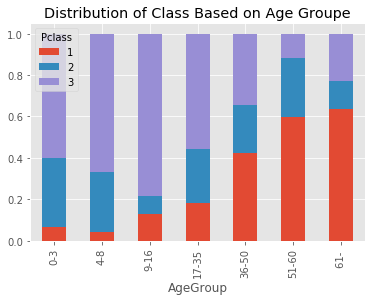

<Figure size 720x360 with 0 Axes>

In [13]:
print(train_data.groupby('Pclass')['Age'].median())
print(train_data.groupby('Sex')['Age'].median())
print(train_data.groupby('Embarked')['Age'].median())
print(train_data.groupby('Survived')['Age'].median())
age_bins = [0,3,8,16,50,60,90]
fig1 = plt.figure()
fig1 = ((train_data.groupby(['AgeGroup','Pclass'])['PassengerId'].count().div(train_data.groupby(['AgeGroup'])['PassengerId'].count())).unstack().plot.bar(stacked=True))
plt.title('Distribution of Class Based on Age Groupe')
plt.figure(figsize = (10,5))


So, a strong correlation between the class and age is observable.  I use this relationship to fill the age missing values by replacing them with the median age of the passenger's class.  

In [14]:
train_data['Age'] = train_data.apply(
    lambda row: train_data.groupby('Pclass')['Age'].median()[row['Pclass']] if np.isnan(row['Age']) else row['Age'],
    axis=1
)

Looking at the cabin missing values tell us that the most them belong to the passengers in the third class. The cabins of the first class were private, but the second class and third class passengers shared large salons. Investigating the distribution of survival chance regarding the cabin number shows that due to a poor registration, the number of the data is too low to become a basis for filling the missing cabin numbers. It can be even misleading as the survival rate for some room numbers is 100% which is in a  contrary to the overall survival rate of the corresponding class. The information the Cabin data can offer is already present in the Class data, as they are directly related.

Text(0.5, 1.0, 'Survival rate Based on Class')

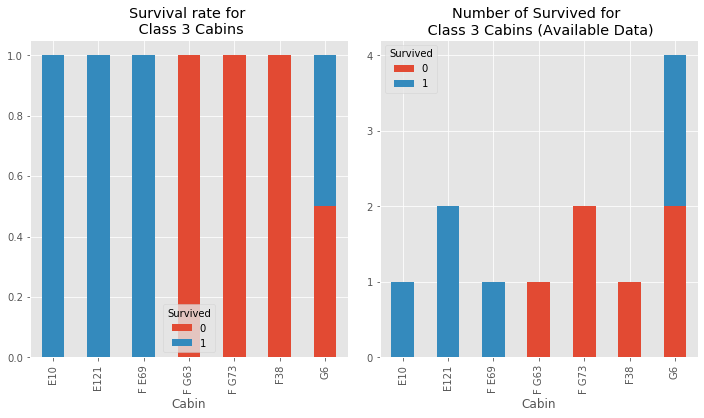

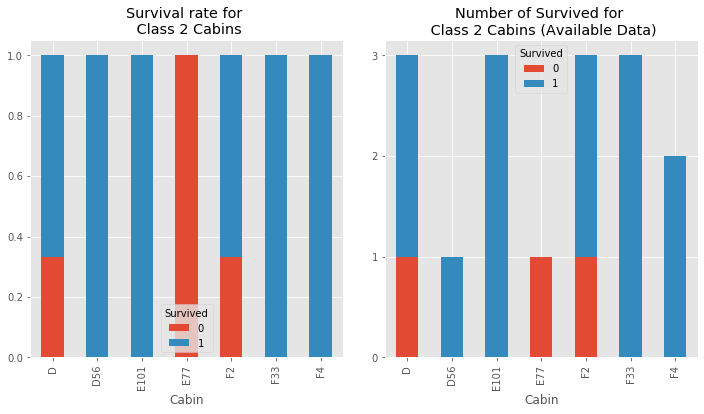

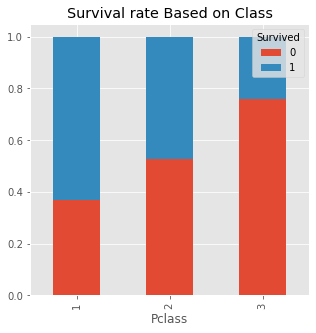

In [15]:
from matplotlib.ticker import MaxNLocator
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
((train_data.groupby([train_data[train_data['Pclass'] == 3]['Cabin'],'Survived'])['PassengerId'].count().div(train_data.groupby(train_data[train_data['Pclass'] == 3]['Cabin'])['PassengerId'].count())).unstack().plot.bar(stacked=True,ax = axes[0]))
axes[0].set_title('Survival rate for \n Class 3 Cabins')
((train_data.groupby([train_data[train_data['Pclass'] == 3]['Cabin'],'Survived'])['PassengerId'].count()).unstack().plot.bar(stacked=True,ax = axes[1]))
axes[1].set_title('Number of Survived for \n Class 3 Cabins (Available Data)')

fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
((train_data.groupby([train_data[train_data['Pclass'] == 2]['Cabin'],'Survived'])['PassengerId'].count().div(train_data.groupby(train_data[train_data['Pclass'] == 2]['Cabin'])['PassengerId'].count())).unstack().plot.bar(stacked=True,ax = axes[0]))
axes[0].set_title('Survival rate for \n Class 2 Cabins')
((train_data.groupby([train_data[train_data['Pclass'] == 2]['Cabin'],'Survived'])['PassengerId'].count()).unstack().plot.bar(stacked=True,ax = axes[1]))
axes[1].set_title('Number of Survived for \n Class 2 Cabins (Available Data)')
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))

fig,ax = plt.subplots(1,1,figsize=(5,5))
(train_data.groupby(['Pclass','Survived'])['Survived'].count()).div(train_data.groupby(['Pclass'])['Survived'].count()).unstack().plot.bar(stacked=True,ax = ax)
ax.set_title('Survival rate Based on Class')


According to the above analysis, I drop the Cabin information.

In [16]:
train_data.drop('Cabin',axis = 1, inplace = True)
train_data.dropna(inplace = True)

Now, let's consider a more scientific method for analyzing the association between the variables. The chi-square test is a method used for finding the dependency between categorical variables. It is based on a comparison between the standard error deviation in case of no association and the actual data. For doing so, I did the following code for calculating the expected number for each category and then finding the chi_square statistics. Smaller p-value means a higher probability of association between the corresponding variables. Here is a useful link for an interested reader:[Chi-Square Test](http://onlinecourses.science.psu.edu/statprogram/node/158)

For the combination of  Survived  and  Pclass  the p-value is  0.0 .
For the combination of  Survived  and  Sex  the p-value is  0.0 .
For the combination of  Survived  and  AgeGroup  the p-value is  0.0002442964840944084 .
For the combination of  Survived  and  Parch  the p-value is  0.00017554602121716556 .
For the combination of  Survived  and  SibSp  the p-value is  0.00038710310777734236 .
For the combination of  Pclass  and  Sex  the p-value is  8.741862966543668e-05 .
For the combination of  Pclass  and  AgeGroup  the p-value is  0.0 .
For the combination of  Pclass  and  Parch  the p-value is  0.9497554997356148 .
For the combination of  Pclass  and  SibSp  the p-value is  0.0003352910912998164 .
For the combination of  Sex  and  AgeGroup  the p-value is  7.640703917988212e-05 .
For the combination of  Sex  and  Parch  the p-value is  1.3719865243899676e-09 .
For the combination of  Sex  and  SibSp  the p-value is  4.5796031498346323e-05 .
For the combination of  AgeGroup  and 

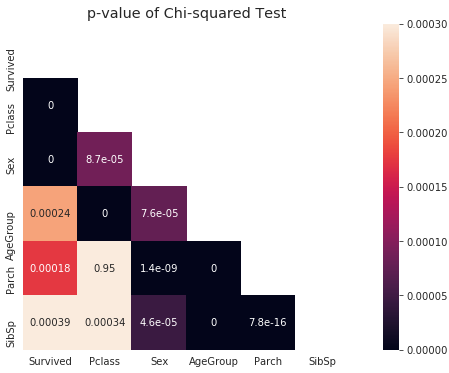

In [17]:
from  itertools import combinations
import scipy.stats as stats

def ExpectedValueCalc(column1,column2):
    n = train_data[column1].nunique()
    m = train_data[column2].nunique()
    table = train_data.groupby([column1,column2])['PassengerId'].count().unstack()
    expected_values = (np.dot(table.sum(axis = 1).values.reshape(n,1),table.sum(axis = 0).\
                              values.reshape(1,m))/(train_data['PassengerId'].count()))
    return expected_values
train_data['AgeGroup'] = pd.cut(train_data['Age'].dropna(),[0,3,8,16,50,60,90],labels = [1,2,3,4,5,6])
columns = ['Survived','Pclass','Sex','AgeGroup','Parch','SibSp']
indexes = ['Survived','Pclass','Sex','AgeGroup','Parch','SibSp']
mat = pd.DataFrame(columns=columns,index = indexes)
for combination in combinations(columns,2):
    EV = ExpectedValueCalc(combination[0],combination[1])
    Table = train_data.groupby([combination[0],combination[1]])['PassengerId'].count().unstack()
    chi_squared_stat = np.square(EV - Table).div(Table).sum().sum()
    n = train_data[combination[0]].nunique()
    m = train_data[combination[1]].nunique()
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,df=(n-1)*(m-1))
    mat.loc[combination[0],combination[1]] = p_value
    print('For the combination of ',combination[0], ' and ',combination[1] ,' the p-value is ' ,p_value,'.')
    
mat = mat.fillna(0)
mask = np.zeros_like(mat)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,6))
with sns.axes_style("white"):
    ax = sns.heatmap(mat.transpose(), mask=mask, vmax=.0003, square=True,annot=True)
    ax.set_title('p-value of Chi-squared Test')

The results mean that there is an association between all the variables. in the other word, all variables contain data that can improve the final classification. In fact, this analysis is the mathematical substitute for the bar charts showing the survival rate based on the other variables. 
For classification, two methods are used here: logistic regression and random forest. I start with the logistic regression. before doing anything further, the categorical data needs to be converted to the numbers. This is done by encoding.
The training data is a sample of 80% from the Train dataset chosen randomly. the rest 20% is used as test data.

In [18]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None

le = preprocessing.LabelEncoder()
X_train = train_data[['Pclass', 'Sex', 'Age', 'SibSp','Parch', 'Fare','Embarked']]
Y_train = train_data['Survived']
for column in ['Sex','Embarked']:
    X_train[column] = le.fit_transform(X_train[column])
    
trainIndex = np.random.rand(X_train.shape[0]) < 0.8
X_train_0 = X_train[trainIndex]
Y_train_0 = Y_train[trainIndex]
X_test_0 = X_train[~trainIndex]
Y_test_0 = Y_train[~trainIndex]

logisticModel = linear_model.LogisticRegression()
logisticModel.fit(X_train_0,Y_train_0)
y_model_logit = logisticModel.predict(X_test_0)
print('Accuracy score of the logestic classifier: ',accuracy_score(y_model_logit,Y_test_0))


Accuracy score of the logestic classifier:  0.782312925170068


C:\Users\fxk160030\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Then, the classification is done by the Random Forest method. For having the best results, a grid search hyperparameter optimization is also conducted for finding the best tree number.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X_train_0 = X_train
Y_train_0 = Y_train
RFModel = RandomForestClassifier()
parameters = {'n_estimators':range(10,300,20)}
clf = GridSearchCV(RFModel, parameters)
clf.fit(X_train_0, Y_train_0)
print('Accuracy score of the random forest classifier: ',clf.best_score_, ' for the following parameters: ',clf.best_params_)



Accuracy score of the random forest classifier:  0.8006106569486852  for the following parameters:  {'n_estimators': 210}
